# **Análise de Dados Após Respetivo Tratamento**

## Imports

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from pandas import DataFrame
from sklearn.preprocessing import KBinsDiscretizer
import statistics
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# matplotlib inline

## Carregar os Dataset de Treino e de Teste

In [66]:
%run "../datasets/parse.ipynb"
train_df = parse_train("../")

## Aplicar Tratamento de Dados

In [67]:
from pandas import DataFrame

In [68]:
numeric_columns = ['Hora', 'Normal (kWh)', 'Horario Economico (kWh)', 'Autoconsumo (kWh)', 'rain_1h','temp','feels_like','temp_min','temp_max','pressure','humidity', 'wind_speed','clouds_all']

categorical_to_numerical = {
    'Injecao na rede (kWh)': {
        'None': 0,
        'Low': 1,
        'Medium': 2,
        'High':3,
        'Very High':4
    },
    'weather_description': {
        'overcast clouds': 0,
        'scattered clouds': 1,
        'few clouds': 2,
        'sky is clear': 3,
        'broken clouds': 4,
        'light rain': 5,
        'moderate rain': 6,
        'heavy intensity rain':7
    },
    'Day' : {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday': 7
    }
}

In [69]:
dropped_columns = ['grnd_level','sea_level','dt']

train_df = train_df.drop(dropped_columns, axis=1)
train_df.head()


,Data,Hora,Normal (kWh),Horario Economico (kWh),Autoconsumo (kWh),Injecao na rede (kWh),city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2022-01-01,0,0.0,0.486,0.0,None,local,16.59,16.00,16.21,16.72,1024,65,3.15,,97,overcast clouds
1,2022-01-01,1,0.0,0.429,0.0,None,local,16.59,16.00,16.21,16.72,1024,65,3.14,,58,broken clouds
2,2022-01-01,2,0.0,0.463,0.0,None,local,16.59,16.03,15.67,16.72,1024,66,3.12,,23,few clouds
3,2022-01-01,3,0.0,0.545,0.0,None,local,13.59,12.75,11.61,16.16,1023,67,3.08,,22,few clouds
4,2022-01-01,4,0.0,0.439,0.0,None,local,14.97,14.27,14.72,15.66,1023,67,3.12,,15,few clouds


In [70]:

def decision_tree_data_preparation(df: DataFrame) -> DataFrame:

    prep_df= df
    prep_df['rain_1h'] = prep_df['rain_1h'].replace('', '0')
    prep_df['rain_1h'] = pd.to_numeric(prep_df['rain_1h'])

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['Data'])

    prep_df['Month'] = record_date.month
    #prep_df['Day'] = record_date.day_name()

    ### Converter as features categoricas em numericas
    prep_df.replace(categorical_to_numerical, inplace=True)

    dropped_columns = ['Data','city_name']
    prep_df = prep_df.drop(dropped_columns, axis=1)
    for value in prep_df['rain_1h']:
        if value==None:
            value=0
    prep_df.loc[(prep_df['Hora'] < 6) & (prep_df['Hora'] > 21), 'Injecao na rede (kWh)'] = 0

    ### Normalizaçao
    prep_df[numeric_columns] = prep_df[numeric_columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

   
    ### Limites superior e inferior (sem outliers) dos diagramas de caixa
    whiskers = []
    for num in numeric_columns:
        Q1 = prep_df[num].quantile(0.25)
        Q3 = prep_df[num].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        whiskers.append((num,lower,upper))

    ### Tratar os outliers das features numéricas:
    ### Substituir os valores dos outliers pela mediana
    for num, lower, upper in whiskers:
        prep_df = prep_df[(prep_df[num] >= lower) & (prep_df[num] <= upper)]

    numeric_columns.append('Injecao na rede (kWh)')
    numeric_columns.append('weather_description')

    return prep_df

In [71]:
prep_df = decision_tree_data_preparation(train_df)

## Exploração dos Dados 

In [72]:
prep_df.head()


,Hora,Normal (kWh),Horario Economico (kWh),Autoconsumo (kWh),Injecao na rede (kWh),temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Month
0,0.000000,0.0,0.185993,0.0,0,0.756744,0.781693,0.770642,0.719495,0.615385,0.569620,0.340308,0.0,0.97,0,1
1,0.043478,0.0,0.164179,0.0,0,0.756744,0.781693,0.770642,0.719495,0.615385,0.569620,0.339207,0.0,0.58,4,1
2,0.086957,0.0,0.177191,0.0,0,0.756744,0.782982,0.745872,0.719495,0.615385,0.582278,0.337004,0.0,0.23,2,1
3,0.130435,0.0,0.208573,0.0,0,0.617209,0.642028,0.559633,0.693315,0.576923,0.594937,0.332599,0.0,0.22,2,1
4,0.173913,0.0,0.168006,0.0,0,0.681395,0.707349,0.702294,0.669939,0.576923,0.594937,0.337004,0.0,0.15,2,1


- Definição do primeiro e do terceiro quartis
- Definição dos valores máximo (*upper*) e mínimo (*lower*)

In [73]:
whiskers = []

for num in numeric_columns:
    Q1 = prep_df[num].quantile(0.25)
    Q3 = prep_df[num].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    whiskers.append((num,lower,upper))

print(whiskers)

[('Hora', -0.5652173913043478, 1.5217391304347825), ('Normal (kWh)', -0.11096585665948938, 0.1849430944324823), ('Horario Economico (kWh)', -0.20206659012629158, 0.336777650210486), ('Autoconsumo (kWh)', -0.3154392191659272, 0.525732031943212), ('temp', 0.06325581395348828, 0.9748837209302326), ('feels_like', 0.08723678556080788, 0.9982810485603782), ('temp_min', 0.019954128440367036, 0.9649082568807339), ('temp_max', 0.07550257129499754, 0.9562879850397383), ('pressure', -0.24999999999999994, 1.4423076923076923), ('humidity', 0.006329113924050556, 1.3734177215189876), ('wind_speed', -0.02808370044052863, 0.5490088105726871), ('clouds_all', -1.43, 2.41), ('Injecao na rede (kWh)', -1.5, 2.5), ('weather_description', -4.5, 7.5)]


## Visualização gráfica dos dados

- Matriz de correlação para valores numéricos

<Axes: >

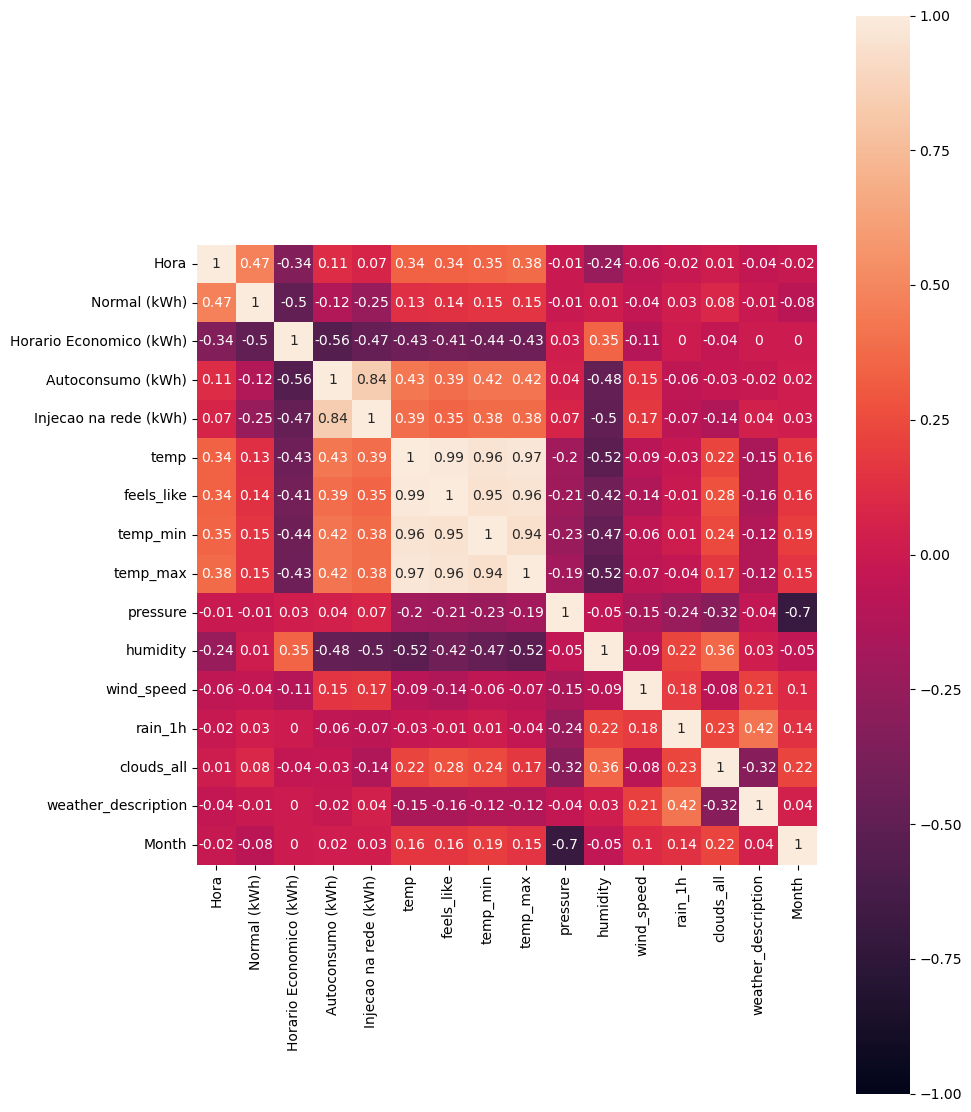

In [74]:
numeric_columns = prep_df.select_dtypes(include=[np.number])
correlationMatrix = numeric_columns.corr().round(2)
f, ax = plt.subplots(figsize=(10, 14))
sns.heatmap(correlationMatrix, vmin=-1, vmax=1, square=True, annot=True)

- Distribuições bivariadas de pares num conjunto de dados

In [75]:
sns.pairplot(prep_df)

- Diagrama de caixa para cada feature numérica

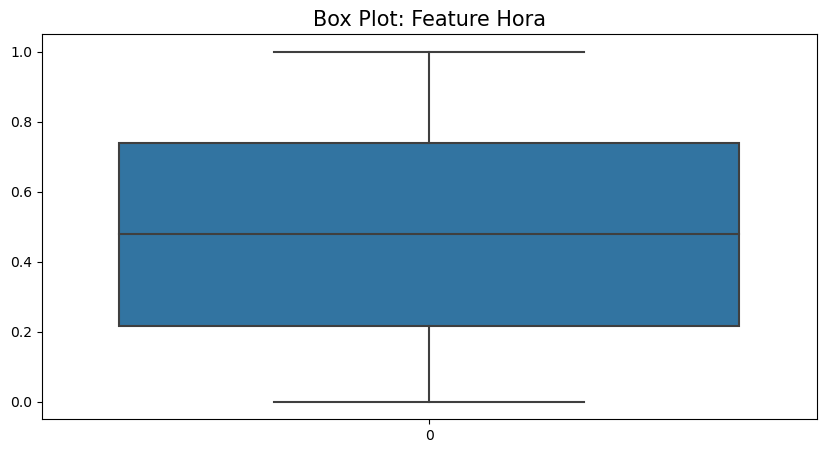

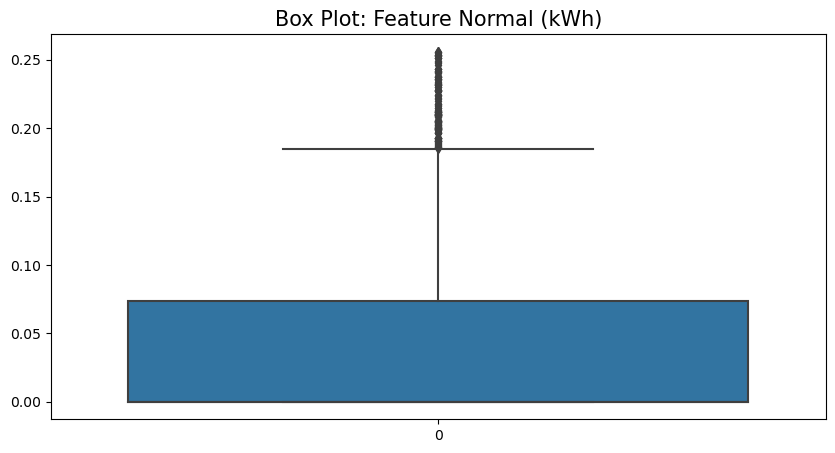

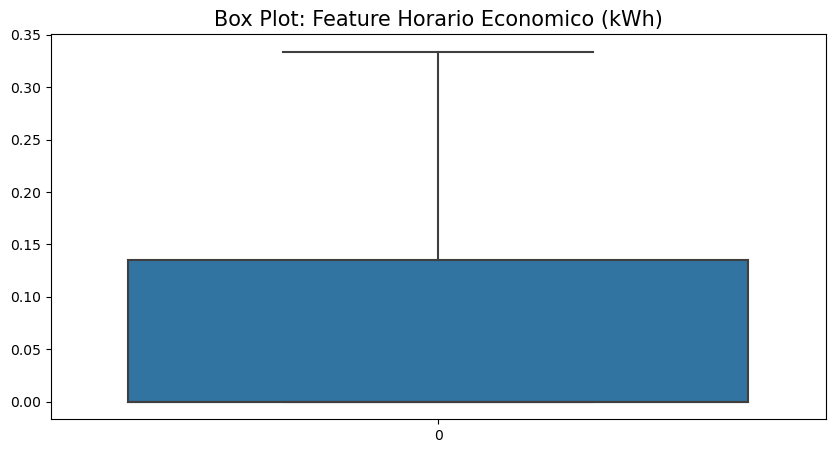

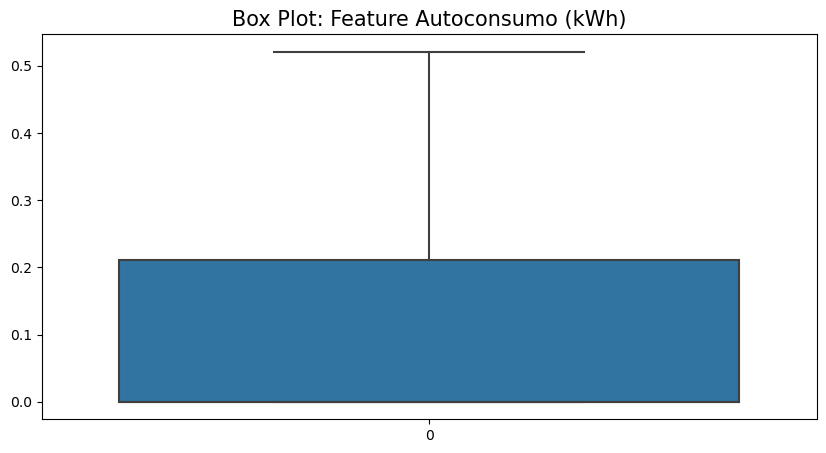

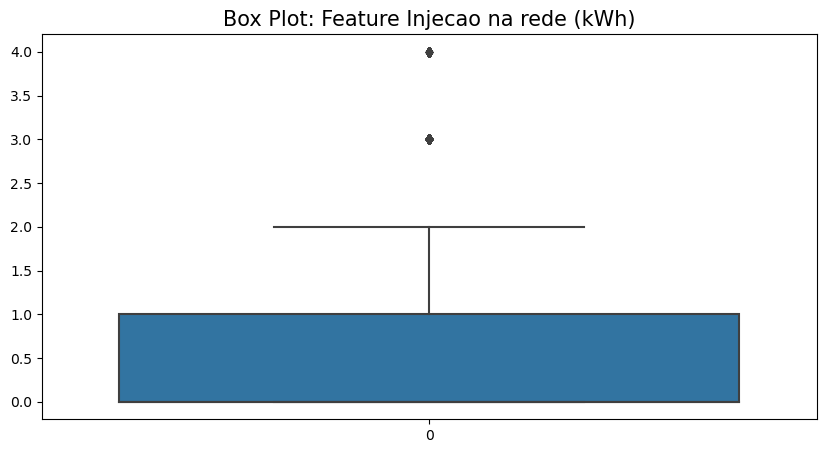

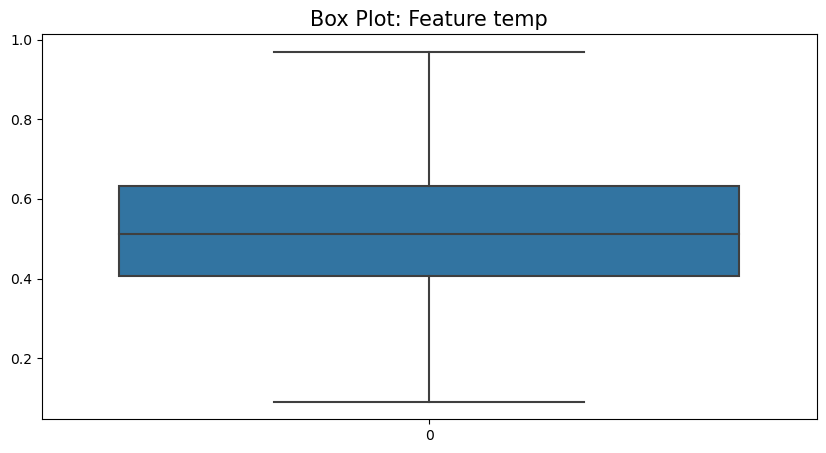

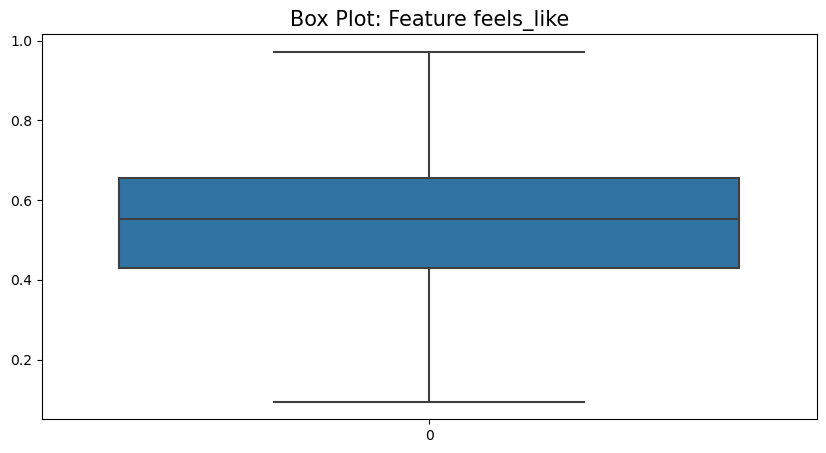

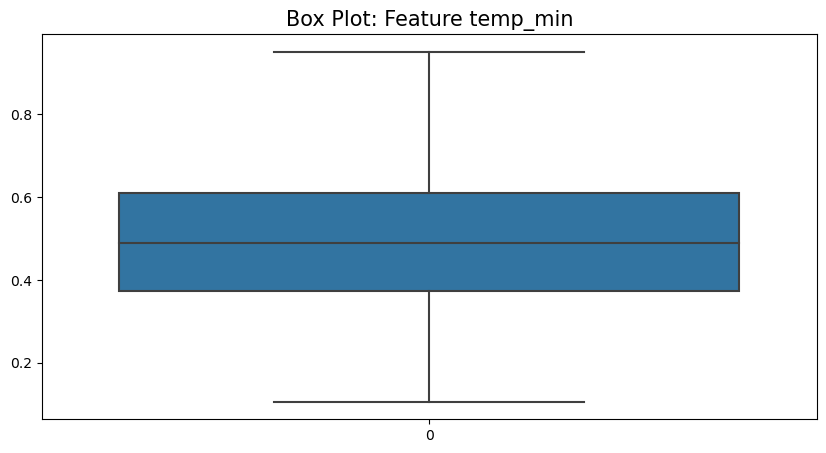

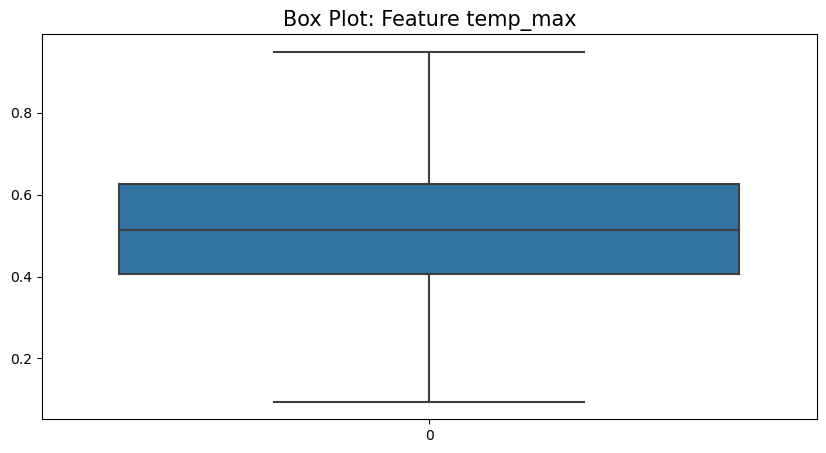

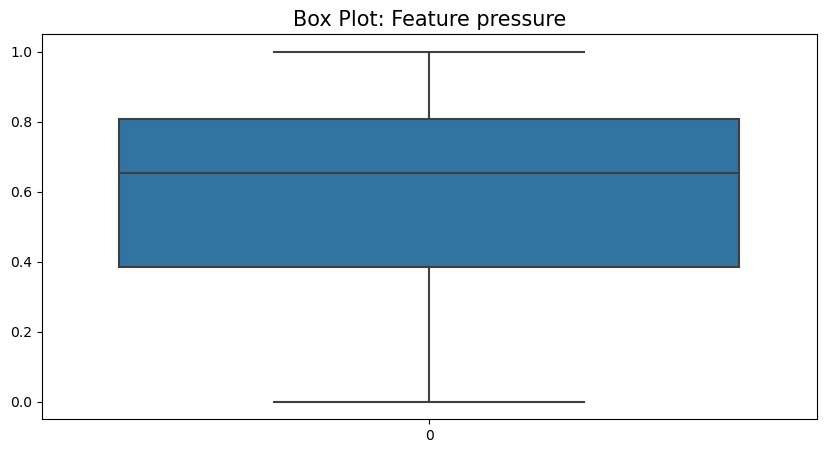

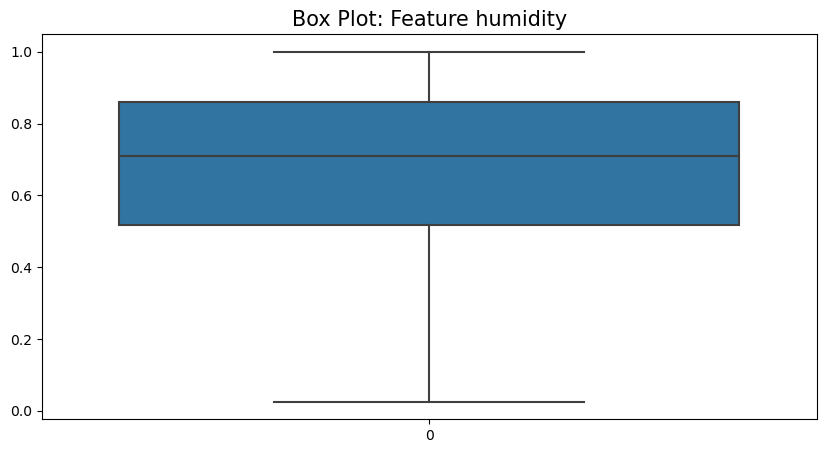

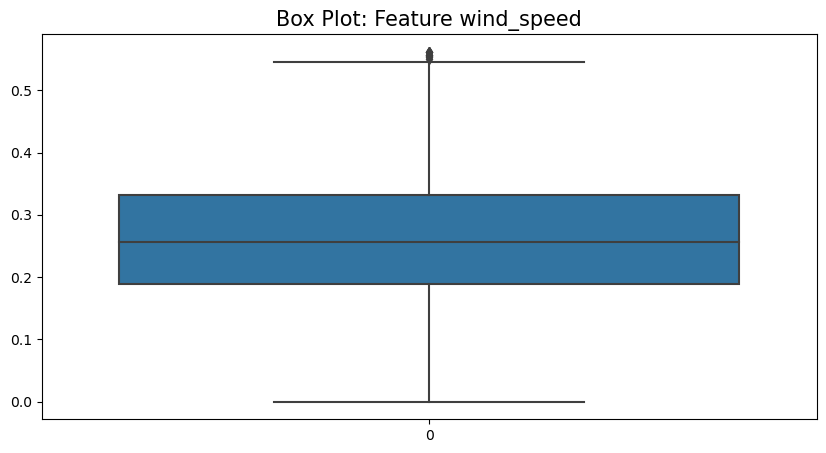

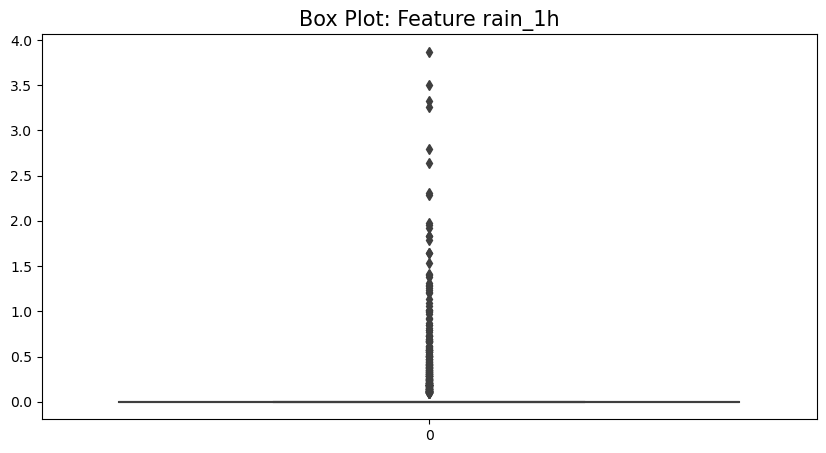

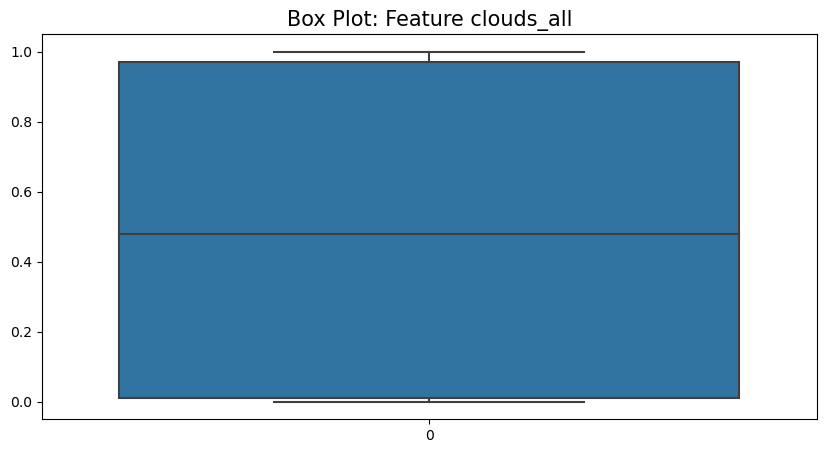

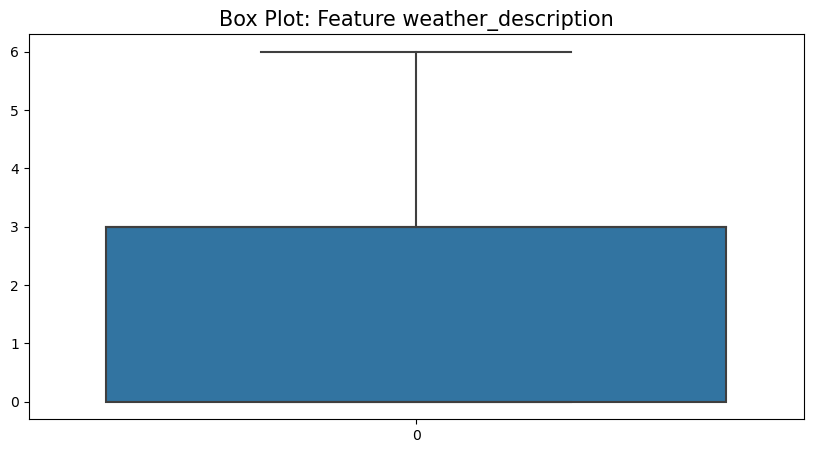

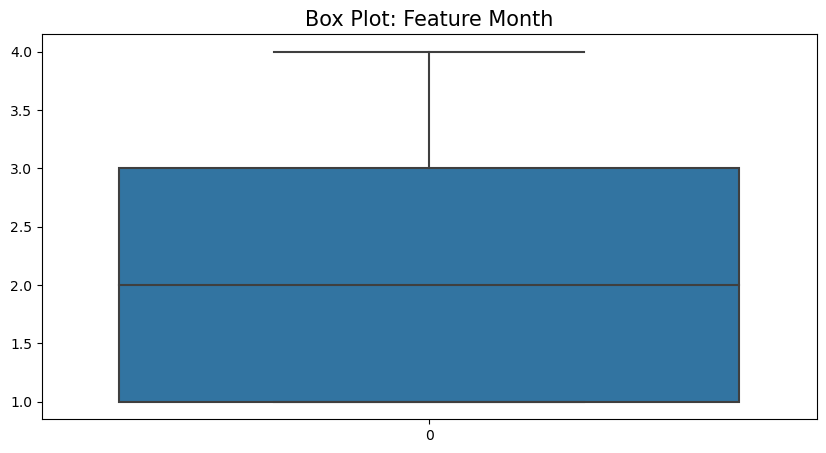

In [ ]:
for num in numeric_columns:
    fig = plt.figure(figsize=(10,5))
    sns.boxplot(prep_df[num])
    plt.title('Box Plot: Feature ' + num, fontsize=15)
    plt.show()

- Quantidade de valores nulos em cada feature

<Axes: >

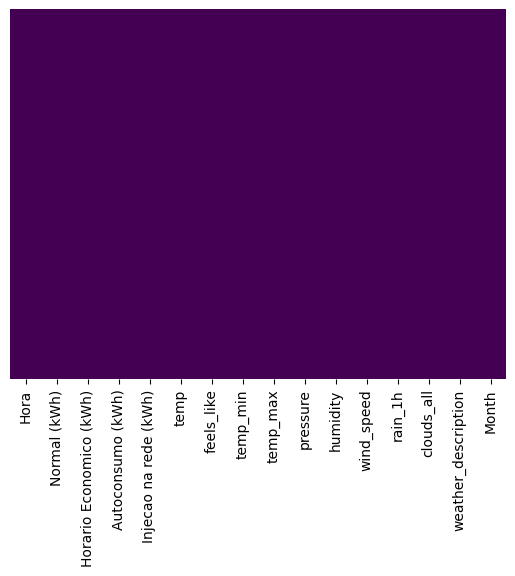

In [ ]:
sns.heatmap(prep_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

- Histograma de um conjunto univariante de observações da feature **incidents** (target)

ValueError: arange: cannot compute length

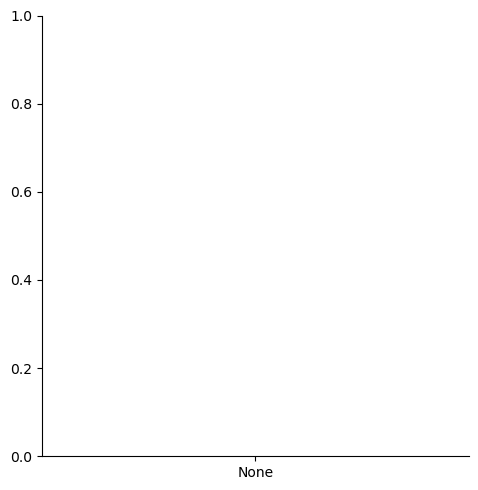

In [ ]:
train_df['Injecao na rede (kWh)'].unique()
train_df['Injecao na rede (kWh)'] = pd.Categorical(train_df['Injecao na rede (kWh)'], categories=['None', 'Low', 'Medium', 'High', 'Very High'])
sns.displot(train_df['Injecao na rede (kWh)'], kde=True)

In [ ]:
sns.displot(prep_df['rain_1h '], kde=True)

KeyError: 'rain_1h '